In [2]:
import pickle
import networkx as nx 
import matplotlib.pyplot as plt
import csv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException
import time
import numpy as np

Large Dataset

In [11]:
pickle_file_path = 'bigger_graph.pickle'

# Open the .pickle file and load its contents
with open(pickle_file_path, 'rb') as file:
    G = pickle.load(file)

# Load the CSV file
song_info = {}
with open('song_data_bigger.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        song_id = row['song_id']
        song_info[song_id] = row

Small Dataset

In [18]:
pickle_file_path = 'small_graph.pickle'

# Open the .pickle file and load its contents
with open(pickle_file_path, 'rb') as file:
    G = pickle.load(file)

# Load the CSV file
song_info = {}
with open('song_data_smaller.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        song_id = row['song_id']
        song_info[song_id] = row

Spotify api connection

In [4]:
client_id = '736dd37c127e4fe698338b94359c87b1'
client_secret = 'e2f427be0bae4ae6aef0e5945d871dfc'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Add features from api

In [19]:
def get_track_data(song_ids):
    retries = 0
    max_retries = 3
    wait_time = 1
    all_track_data = []

    while retries < max_retries:
        try:
            audio_features_list = sp.audio_features(song_ids)
            track_details_list = sp.tracks(song_ids)['tracks']
            
            for audio_features, track_details in zip(audio_features_list, track_details_list):
                if track_details:
                    # Assuming the first artist is the primary one
                    artist_uri = track_details['artists'][0]['uri']
                    artist_details = sp.artist(artist_uri)
                    artist_popularity = artist_details['popularity']
                else:
                    artist_popularity = None

                track_data = {
                    'audio_features': audio_features,
                    'popularity': track_details['popularity'] if track_details else None,
                    'artist_popularity': artist_popularity
                }
                all_track_data.append(track_data)
            return all_track_data
        except SpotifyException as e:
            if e.http_status == 429 or 'max retries' in str(e):
                print(f"Rate limited. Waiting for {wait_time} seconds.")
                time.sleep(wait_time)
                wait_time *= 2
                retries += 1
            else:
                raise
    return None


batch_size = 50
song_ids = list(song_info.keys())  # Get a list of all song IDs from the dictionary

for i in range(0, len(song_ids), batch_size):
    batch_song_ids = song_ids[i:i+batch_size]  # Collect a batch of song IDs
    tracks_data = get_track_data(batch_song_ids)  # Fetch track data for the batch

    if tracks_data:
        for track_data, song_id in zip(tracks_data, batch_song_ids):
            if track_data and track_data['audio_features']:
                # Update each song's information in `song_info` dictionary
                song_info[song_id]['energy'] = track_data['audio_features']['energy']
                song_info[song_id]['valence'] = track_data['audio_features']['valence']
                song_info[song_id]['danceability'] = track_data['audio_features']['danceability']
                song_info[song_id]['tempo'] = track_data['audio_features']['tempo']
                song_info[song_id]['loudness'] = track_data['audio_features']['loudness']
                song_info[song_id]['acousticness'] = track_data['audio_features']['acousticness']
                song_info[song_id]['instrumentalness'] = track_data['audio_features']['instrumentalness']
                song_info[song_id]['liveness'] = track_data['audio_features']['liveness']
                song_info[song_id]['speechiness'] = track_data['audio_features']['speechiness']
                song_info[song_id]['duration_ms'] = track_data['audio_features']['duration_ms']  
                song_info[song_id]['popularity'] = track_data['popularity']
                song_info[song_id]['time_signature'] = track_data['audio_features']['time_signature']
                song_info[song_id]['artist_popularity'] = track_data['artist_popularity']
            else:
                # Set attributes to None if there's no data
                song_info[song_id]['energy'] = None
                song_info[song_id]['valence'] = None
                song_info[song_id]['danceability'] = None
                song_info[song_id]['tempo'] = None
                song_info[song_id]['loudness'] = None
                song_info[song_id]['acousticness'] = None
                song_info[song_id]['instrumentalness'] = None
                song_info[song_id]['liveness'] = None
                song_info[song_id]['speechiness'] = None
                song_info[song_id]['popularity'] = None
                song_info[song_id]['duration_ms'] = None
                song_info[song_id]['time_signature'] = None
                song_info[song_id]['artist_popularity'] = None

Basic network metrics

In [ ]:
# Compute metrics
def max_metric(metric):
    return max(metric.values())

# Function to calculate the minimum of a dictionary
def min_metric(metric):
    return min(metric.values())

# Function to calculate the average of a dictionary
def avg_metric(metric):
    return sum(metric.values()) / len(metric)

# Function to calculate the median of a dictionary
def median_metric(metric):
    sorted_metric = sorted(metric.values())
    n = len(sorted_metric)
    if n % 2 == 0:
        return (sorted_metric[n//2] + sorted_metric[n//2 - 1]) / 2
    return sorted_metric[n//2]


# Danceability
average_danceability = avg_metric({k: float(v['danceability']) for k, v in song_info.items()})
average_energy = avg_metric({k: float(v['energy']) for k, v in song_info.items()})
average_valence = avg_metric({k: float(v['valence']) for k, v in song_info.items()})
average_tempo = avg_metric({k: float(v['tempo']) for k, v in song_info.items()})
average_duration = avg_metric({k: float(v['duration_ms']) for k, v in song_info.items()})
average_loudness = avg_metric({k: float(v['loudness']) for k, v in song_info.items()})
average_acousticness = avg_metric({k: float(v['acousticness']) for k, v in song_info.items()})
average_instrumentalness = avg_metric({k: float(v['instrumentalness']) for k, v in song_info.items()})
average_liveness = avg_metric({k: float(v['liveness']) for k, v in song_info.items()})
average_speechiness = avg_metric({k: float(v['speechiness']) for k, v in song_info.items()})
average_popularity = avg_metric({k: float(v['popularity']) for k, v in song_info.items()})
average_artist_popularity = avg_metric({k: float(v['artist_popularity']) for k, v in song_info.items()})



Plot correlation

To change feature, edit x declaration 

To change metric edit y declaration and change metric = degree[node] to the metric 

In [ ]:
feature_values = []
metric_values = []
counter = 0
x = 'closeness_centrality'  # edit this to change the feature
y = 'degree'  # edit this to change the metric

# Iterate over the nodes in the network
for node in G.nodes():
    feature = closeness_centrality[node]  # edit this to change the feature
    metric = degree[node]  # edit this to change the metric

    if feature is not None and feature != 0:
        feature_values.append(float(feature))
        metric_values.append(metric)

    if feature == 0:
        counter += 1

correlation_coefficient = np.corrcoef(feature_values, metric_values)[0, 1]
print(f"Correlation coefficient: {correlation_coefficient}")
print(f"Number of songs with {x} 0: {counter}")

# Calculate the line of best fit
slope, intercept = np.polyfit(feature_values, metric_values, 1)
line_of_best_fit = np.array(feature_values) * slope + intercept

# Plot the correlation between x and y with the line of best fit
plt.figure()
plt.scatter(feature_values, metric_values)
plt.plot(feature_values, line_of_best_fit, color='red')  # Line of best fit
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.title(f'Correlation between {x} and {y}')
plt.show()


In [ ]:
well_connected_nodes = []
for node in G.nodes():
    if degree_centrality[node] > avg_degree_centrality + 3 * std_degree_centrality:
        well_connected_nodes.append(node)

print(f"Number of well-connected nodes: {len(well_connected_nodes)}")
for node in well_connected_nodes:
    print(f"Name: {song_info[node]['song_name']}, Degree Centrality: {degree_centrality[node]}, Danceability: {song_info[node]['danceability']}")

# Create lists to store song names and danceability scores
song_names = []
danceability_scores = []

for node in well_connected_nodes:
    print(f"Name: {song_info[node]['song_name']}, Degree Centrality: {degree_centrality[node]}, Danceability: {song_info[node]['danceability']}")
    song_names.append(song_info[node]['song_name'])
    danceability_scores.append(song_info[node]['danceability'])

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(song_names, danceability_scores)
ax.set_xlabel('Song Name')
ax.set_ylabel('Danceability Score')
ax.set_title('Danceability Scores of Well-Connected Nodes')
ax.set_xticklabels(song_names, rotation=45, ha='right', fontsize=5)
plt.tight_layout()
plt.show()

print(f"Average Danceability Score: {average_danceability}")


In [ ]:
#List of attributes to check
attributes = ['valence', 'energy', 'speechiness']

#Calculate the top 5% of nodes by degree
top_percentile = int(0.05 * len(G))
top_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_percentile]

#Extracting the node IDs from the top_degree_nodes
top_nodes_ids = [node for node, degree in top_degree_nodes]

#Loop over each attribute to plot their distribution among well-connected nodes
for attribute in attributes:
    # Extract attribute values for well-connected nodes
    top_attribute_values = [float(song_info[node][attribute]) for node in top_nodes_ids if attribute in song_info[node]]

    # Plotting the distribution of the attribute
    plt.hist(top_attribute_values, bins=10, alpha=0.75, color='blue')
    plt.title(f'Distribution of {attribute.capitalize()} among Well-Connected Nodes')
    plt.xlabel(attribute.capitalize())
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#Calculate and print out the mean and standard deviation for the attribute
    mean_val = np.mean(top_attribute_values)
    std_val = np.std(top_attribute_values)

    print(f"Mean {attribute.capitalize()}: {mean_val:.2f}")
    print(f"Standard Deviation of {attribute.capitalize()}: {std_val:.2f}")
    print("---\n")

print each node info

In [ ]:
# Iterate over the nodes in the network
for node in G.nodes():
    print(f"Node: {node}")
    
    # Access the attributes of the node
    attributes = G.nodes[node]
    
    # Print the attributes
    for attr_name, attr_value in attributes.items():
        print(f"{attr_name}: {attr_value}")
    
    # Access additional song information from the CSV file
    song_data = song_info[node]
    print(f"Song Name: {song_data['song_name']}")
    print(f"Artist Name: {song_data['artist_name']}")
    print(f"Artist URI: {song_data['artist_uri']}")
    print(f"Album Name: {song_data['album_name']}")
    print(f"Album URI: {song_data['album_uri']}")
    print("popularity:", song_data['popularity'])
    print("energy:", song_data['energy'])
    print("valence:", song_data['valence'])
    print("danceability:", song_data['danceability'])
    print("tempo:", song_data['tempo'])
    print("loudness:", song_data['loudness'])
    print("acousticness:", song_data['acousticness'])
    print("instrumentalness:", song_data['instrumentalness'])
    print("liveness:", song_data['liveness'])
    print("speechiness:", song_data['speechiness'])
    print("duration_ms:", song_data['duration_ms'])#
    print("time_signature:", song_data['time_signature'])
    print("artist_popularity:", song_data['artist_popularity'])
    print(f"Degree: {degree[node]}")
    print(f"Degree Centrality: {degree_centrality[node]}")
    print(f"Betweenness Centrality: {betweenness_centrality[node]}")
    print(f"Closeness Centrality: {closeness_centrality[node]}")
    print(f"Eigenvector Centrality: {eigenvector_centrality[node]}")
    print(f"Clustering Coefficient: {clustering_coefficient[node]}")
    print("---")

print basic network stats

In [16]:
# Print the metrics
print("Max degree:", max_degree, "Node:", max(degree, key=degree.get), "Song Name:", song_info[max(degree, key=degree.get)]['song_name']) 
print("Min degree:", min_degree, "Node:", min(degree, key=degree.get), "Song Name:", song_info[min(degree, key=degree.get)]['song_name']) 
print("Average degree:", avg_degree)
print("Median degree:", median_degree)
print("---")

print("Max degree centrality:", max_degree_centrality, "Node:", max(degree_centrality, key=degree_centrality.get), "Song Name:", song_info[max(degree_centrality, key=degree_centrality.get)]['song_name'])
print("Min degree centrality:", min_degree_centrality, "Node:", min(degree_centrality, key=degree_centrality.get), "Song Name:", song_info[min(degree_centrality, key=degree_centrality.get)]['song_name'])
print("Average degree centrality:", avg_degree_centrality)
print("Median degree centrality:", median_degree_centrality)
print("---")

print("Max betweenness centrality:", max_betweenness_centrality, "Node:", max(betweenness_centrality, key=betweenness_centrality.get), "Song Name:", song_info[max(betweenness_centrality, key=betweenness_centrality.get)]['song_name'])
print("Min betweenness centrality:", min_betweenness_centrality, "Node:", min(betweenness_centrality, key=betweenness_centrality.get), "Song Name:", song_info[min(betweenness_centrality, key=betweenness_centrality.get)]['song_name'])
print("Average betweenness centrality:", avg_betweenness_centrality)
print("Median betweenness centrality:", median_betweenness_centrality)
print("---")

print("Max closeness centrality:", max_closeness_centrality, "Node:", max(closeness_centrality, key=closeness_centrality.get), "Song Name:", song_info[max(closeness_centrality, key=closeness_centrality.get)]['song_name'])
print("Min closeness centrality:", min_closeness_centrality, "Node:", min(closeness_centrality, key=closeness_centrality.get), "Song Name:", song_info[min(closeness_centrality, key=closeness_centrality.get)]['song_name'])
print("Average closeness centrality:", avg_closeness_centrality)
print("Median closeness centrality:", median_closeness_centrality)
print("---")

print("Max eigenvector centrality:", max_eigenvector_centrality, "Node:", max(eigenvector_centrality, key=eigenvector_centrality.get), "Song Name:", song_info[max(eigenvector_centrality, key=eigenvector_centrality.get)]['song_name'])
print("Min eigenvector centrality:", min_eigenvector_centrality, "Node:", min(eigenvector_centrality, key=eigenvector_centrality.get), "Song Name:", song_info[min(eigenvector_centrality, key=eigenvector_centrality.get)]['song_name'])
print("Average eigenvector centrality:", avg_eigenvector_centrality)
print("Median eigenvector centrality:", median_eigenvector_centrality)
print("---")

print("Max clustering coefficient:", max_clustering_coefficient, "Node:", max(clustering_coefficient, key=clustering_coefficient.get), "Song Name:", song_info[max(clustering_coefficient, key=clustering_coefficient.get)]['song_name'])
print("Min clustering coefficient:", min_clustering_coefficient, "Node:", min(clustering_coefficient, key=clustering_coefficient.get), "Song Name:", song_info[min(clustering_coefficient, key=clustering_coefficient.get)]['song_name'])
print("Average clustering coefficient:", avg_clustering_coefficient)
print("Median clustering coefficient:", median_clustering_coefficient)
print("---")

print("Average danceability:", average_danceability)
print("Average energy:", average_energy)
print("Average valence:", average_valence)
print("Average tempo:", average_tempo)
print("Average duration", average_duration)
print("Average popularity:", average_popularity)
print("Average acousticness:", average_acousticness)
print("Average speechiness:", average_speechiness)
print("Average liveness:", average_liveness)
print("Average instrumentalness:", average_instrumentalness)
print("Average loudness:", average_loudness)
print("---")

print("Average path length:", avg_path_length) 
print("---")

if nx.is_directed(G):
    print("The graph is directed.")
else:
    print("The graph is undirected.")

if nx.is_connected(G):
    print("The graph is connected.")
else:
    print("The graph is not connected.")
    num_components = nx.number_connected_components(G)
    print(f"The graph has {num_components} connected components.")

Average danceability: 0.6348077340079509
Average energy: 0.6712736176364293
Average valence: 0.5106518612215396
Average tempo: 121.9188677267799
Average duration 232287.9262739429
Average popularity: 45.13552584026021
Average acousticness: 0.17659211044452475
Average speechiness: 0.09982808095410192
Average liveness: 0.18208398988073726
Average instrumentalness: 0.013579751167329238
Average loudness: -6.55351102276834
---
Average path length: 3.29907723950082
---
The graph is undirected.
The graph is connected.


draw networks

In [ ]:
# Draw unweighted graph
def draw_unweighted(G, pos, node_color, edge_color, linewidths, border_color):
    node_size = 200
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color , linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    plt.title("Unweighted") 
    plt.show()

# Draw weighted graph by degree
def draw_degree(G, pos, node_color, edge_color, linewidths, border_color, degree, max_degree, song_info):
    node_size = [(degree[node] * 4 + 20) for node in G.nodes()]
    labels = {}
    labels[max_degree] = song_info[max_degree]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Degree")
    plt.show()

# Draw weighted graph by degree centrality
def draw_degree_centrality(G, pos, node_color, edge_color, linewidths, border_color, degree_centrality, song_info):
    node_size = [(((degree_centrality[node])* 60) ** 3 + 20) for node in G.nodes()]
    labels = {}
    max_degree_centrality = max(degree_centrality, key=degree_centrality.get)
    labels[max_degree_centrality] = song_info[max_degree_centrality]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Degree Centrality")
    plt.show()

# Draw weighted graph by betweenness centrality
def draw_betweenness_centrality(G, pos, node_color, edge_color, linewidths, border_color, betweenness_centrality, song_info):
    node_size = [(((betweenness_centrality[node] + 0.0001)* 200) ** 2 + 20) for node in G.nodes()]
    labels = {}
    max_betweenness_centrality = max(betweenness_centrality, key=betweenness_centrality.get)
    labels[max_betweenness_centrality] = song_info[max_betweenness_centrality]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Betweenness Centrality")
    plt.show()

# Draw weighted graph by closeness centrality
def draw_closeness_centrality(G, pos, node_color, edge_color, linewidths, border_color, closeness_centrality, song_info):
    node_size = [((closeness_centrality[node] * 12) ** 4) for node in G.nodes()]
    labels = {}
    max_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)
    labels[max_closeness_centrality] = song_info[max_closeness_centrality]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Closeness Centrality")
    plt.show()

# Draw weighted graph by eigenvector centrality
def draw_eigenvector_centrality(G, pos, node_color, edge_color, linewidths, border_color, eigenvector_centrality, song_info):
    node_size = [((eigenvector_centrality[node] * 1200) ** 1.2 + 60) for node in G.nodes()]
    labels = {}
    max_eigenvector_centrality = max(eigenvector_centrality, key=eigenvector_centrality.get)
    labels[max_eigenvector_centrality] = song_info[max_eigenvector_centrality]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Eigenvector Centrality")
    plt.show()

In [ ]:
# Draw weighted graph by degree
def draw_degree(G, pos, node_color, edge_color, linewidths, border_color, degree, max_degree, song_info):
    node_size = [(degree[node] * 4 + 20) for node in G.nodes()]
    labels = {}
    labels[max_degree] = song_info[max_degree]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Degree")
    plt.show()


In [62]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

def draw_degree(G, pos, edge_color, linewidths, border_color, degree, max_degree, song_info):
    node_size = [(degree[node] * 4 + 20) for node in G.nodes()]
    labels = {}
    labels[max_degree] = song_info[max_degree]['song_name']
    
    # Create a list of danceability values for each node
    danceability_values = [song_info[node]['danceability'] for node in G.nodes()]
    
    # Normalize the danceability values to a range of 0 to 1
    normalized_danceability = [value / 100 for value in danceability_values]
    
    # Create a colormap
    cmap = cm.get_cmap('viridis')
    
    # Map the normalized danceability values to colors using the colormap
    node_color = [cmap(value) for value in normalized_danceability]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    
    # Create a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Danceability')
    
    plt.title("Degree")
    plt.show()

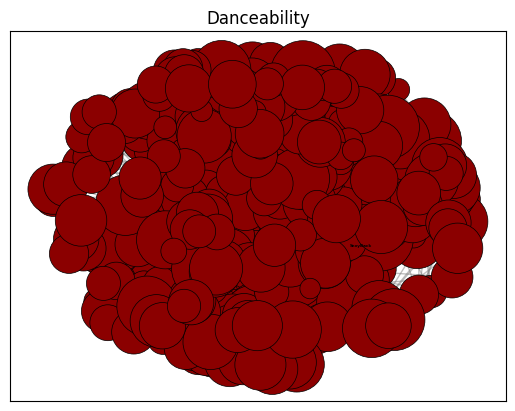

Average Danceability:  0.6177877094972067


In [65]:
def draw_danceability(G, pos, node_color, edge_color, linewidths, border_color, song_info):
    danceability = {node: song_info[node]['danceability'] for node in G.nodes()}
    # normalize the danceability values
    #danceability = {k: (v - min(danceability.values())) / (max(danceability.values()) - min(danceability.values())) for k, v in danceability.items()}
    node_size = [((danceability[node] * 50) **1.5 ) for node in G.nodes()]
    labels = {}
    max_danceability = max(danceability, key=danceability.get)
    labels[max_danceability] = song_info[max_danceability]['song_name']

    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors=border_color, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=3, font_weight='bold')
    plt.title("Danceability")
    plt.show()

    # Draw the network    
node_colors = 'darkred'
border_color = 'black'
edge_color = 'gray'
linewidths = 0.5
labels = {}
largest_node = max(degree, key=degree.get)
labels[largest_node] = song_info[largest_node]['song_name']

pos = nx.spring_layout(G, k=3, iterations=300)
draw_danceability(G, pos, node_colors, edge_color, linewidths, border_color, song_info)
print("Average Danceability: ", average_danceability)